In [1]:
!pip install 'zarr<3'
!pip install timm


Defaulting to user installation because normal site-packages is not writeable
  Using cached zarr-2.18.7-py3-none-any.whl.metadata (5.8 kB)
  Using cached asciitree-0.3.3-py3-none-any.whl
  Using cached fasteners-0.20-py3-none-any.whl.metadata (4.8 kB)
  Using cached numcodecs-0.15.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.9 kB)
  Using cached deprecated-1.3.1-py2.py3-none-any.whl.metadata (5.9 kB)
Using cached zarr-2.18.7-py3-none-any.whl (211 kB)
Using cached numcodecs-0.15.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.9 MB)
Using cached fasteners-0.20-py3-none-any.whl (18 kB)
Using cached deprecated-1.3.1-py2.py3-none-any.whl (11 kB)

[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Using cached timm-1.0.24-py3-none-any.whl.metadata (38 kB)
Using cached timm-1.0.24-py3-none-any.whl (2.6 MB)

[not

In [1]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


## Data Loading

In [2]:
# Cell 3: Import and create dataloaders
from dataset import Config, create_dataloaders

# Just use the correct relative path from your working directory
config = Config("configs/config_fold1.yaml")  # Note: "configs" not "config"
config.print_config()

train_loader, val_loader, test_loader = create_dataloaders(config)
print("\n✅ Ready to use!")

✅ CRC Dataset Package v1.0.0 loaded
CRC DATASET CONFIGURATION
Config File: configs/config_fold1.yaml
Zarr Base: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/ORION-CRC/zarr_data
Cache: ./cache/multimodal_dataset_cache_fold1.pkl
Strategy: memory

📊 Data Splits:
  Train: 33 samples
  Val: 9 samples
  Test: 8 samples

🔄 DataLoader:
  Batch Size: 4
  Num Workers: 0
  Pin Memory: True

🎨 Augmentation:
  Training: True
  Probability: 0.0

🎯 HV Maps:
  Generate: True
  Method: pannuke
  HE Nuclei: True
  HE Cells: True
  MIF Nuclei: True
  MIF Cells: True

🔍 Filtering:
  Min Instances: 0
  Filter Empty: True

CREATING DATALOADERS
Strategy: memory
Use Cache: True
Batch Size: 4
Num Workers: 0

Train split: 27 CRC + 6 Xenium samples
Val split: 7 CRC + 2 Xenium samples
Test split: 7 CRC + 1 Xenium samples

📦 Loading from cache: ./cache/combined_cache_train_cfd81fe4.pkl
📦 Loaded 2892 patches from cache
📦 Loading from cache: ./cache/combined_cache_val_54d8d998.pkl
📦 Loaded 1654 patches f

## Train

In [3]:
# Cell 1: Import
from vitaminp import VitaminPDual,VitaminPFlex, VitaminPTrainer
import torch

# Cell 3: Initialize model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VitaminPFlex(model_size='large',freeze_backbone=False)

# Cell 4: Initialize trainer
trainer = VitaminPTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    lr=1e-4,
    weight_decay=1e-4,
    fold=2,
    use_wandb=False,
    project_name="vitamin-p-channel_shuffling",
    run_name="VitaminPFlex-large-fold2-test",
    checkpoint_dir="checkpoints/test/"
)

# Cell 5: Train
trainer.train(epochs=250, use_augmentations=True)

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ VitaminPFlex initialized with large backbone
  Architecture: Shared Encoder → 4 Separate Decoders
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]
Training VitaminPFlex-LARGE
Epochs: 250 | LR: 0.0001
Augmentations: True


Training:   0%|                                                                                                     | 0/723 [00:00<?, ?it/s]


KeyboardInterrupt: 

## HE metrics

In [ ]:

import torch
from metrics import (
    dice_coefficient, 
    iou_score, 
    panoptic_quality,
    aggregated_jaccard_index,
    compute_batch_metrics,
    print_metrics
)
import numpy as np
from vitaminp import VitaminPFlex, SimplePreprocessing, prepare_he_input
from postprocessing import process_model_outputs

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ========== LOAD TRAINED MODEL ==========
print("\n📦 Loading trained model...")

model = VitaminPFlex(model_size='large').to(device)
checkpoint_path = "checkpoints/vitamin_p_flex_large_fold2_best.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

print(f"✅ Loaded checkpoint: {checkpoint_path}")
print(f"✅ Model: VitaminP-Flex-Large")


# ========== PREPROCESSING (use classes from previous cell) ==========
preprocessor = SimplePreprocessing()

# ========== EVALUATE ON TEST DATA ==========
print("\n🧪 Evaluating on test set...")
model.eval()

all_metrics = {
    'he_nuclei_dice': [], 'he_nuclei_iou': [],
    'he_cell_dice': [], 'he_cell_iou': [],
    'mif_nuclei_dice': [], 'mif_nuclei_iou': [],
    'mif_cell_dice': [], 'mif_cell_iou': []
}

with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        
        # ===== H&E Evaluation =====
        he_img = prepare_he_input(batch['he_image'].to(device))
        he_img = preprocessor.percentile_normalize(he_img)
        
        nuclei_mask_gt = batch['he_nuclei_mask'].float().unsqueeze(1).to(device)
        cell_mask_gt = batch['he_cell_mask'].float().unsqueeze(1).to(device)
        
        # Forward pass
        outputs_he = model(he_img)
        
        # Predictions
        pred_nuclei_he = (outputs_he['he_nuclei_seg'] > 0.5).float()
        pred_cell_he = (outputs_he['he_cell_seg'] > 0.5).float()
        
        # Compute metrics - FIXED: removed .item() since metrics already return floats
        he_nuclei_dice = dice_coefficient(pred_nuclei_he, nuclei_mask_gt)
        he_nuclei_iou = iou_score(pred_nuclei_he, nuclei_mask_gt)
        he_cell_dice = dice_coefficient(pred_cell_he, cell_mask_gt)
        he_cell_iou = iou_score(pred_cell_he, cell_mask_gt)
        
        all_metrics['he_nuclei_dice'].append(he_nuclei_dice)
        all_metrics['he_nuclei_iou'].append(he_nuclei_iou)
        all_metrics['he_cell_dice'].append(he_cell_dice)
        all_metrics['he_cell_iou'].append(he_cell_iou)
        
        # ===== MIF Evaluation =====
        mif_img = prepare_mif_input(batch['mif_image'].to(device))
        mif_img = preprocessor.percentile_normalize(mif_img)
        
        outputs_mif = model(mif_img)
        
        # Predictions
        pred_nuclei_mif = (outputs_mif['mif_nuclei_seg'] > 0.5).float()
        pred_cell_mif = (outputs_mif['mif_cell_seg'] > 0.5).float()
        
        mif_nuclei_dice = dice_coefficient(pred_nuclei_mif, nuclei_mask_gt)
        mif_nuclei_iou = iou_score(pred_nuclei_mif, nuclei_mask_gt)
        mif_cell_dice = dice_coefficient(pred_cell_mif, cell_mask_gt)
        mif_cell_iou = iou_score(pred_cell_mif, cell_mask_gt)
        
        all_metrics['mif_nuclei_dice'].append(mif_nuclei_dice)
        all_metrics['mif_nuclei_iou'].append(mif_nuclei_iou)
        all_metrics['mif_cell_dice'].append(mif_cell_dice)
        all_metrics['mif_cell_iou'].append(mif_cell_iou)
        
        # Print progress every 10 batches
        if (batch_idx + 1) % 10 == 0:
            print(f"Processed {batch_idx + 1}/{len(test_loader)} batches...")

# ========== AGGREGATE RESULTS ==========
print("\n" + "="*80)
print("📊 TEST SET RESULTS")
print("="*80)

print("\n🔬 H&E Performance:")
print(f"  Nuclei Dice: {sum(all_metrics['he_nuclei_dice'])/len(all_metrics['he_nuclei_dice']):.4f} ± {torch.tensor(all_metrics['he_nuclei_dice']).std():.4f}")
print(f"  Nuclei IoU:  {sum(all_metrics['he_nuclei_iou'])/len(all_metrics['he_nuclei_iou']):.4f} ± {torch.tensor(all_metrics['he_nuclei_iou']).std():.4f}")
print(f"  Cell Dice:   {sum(all_metrics['he_cell_dice'])/len(all_metrics['he_cell_dice']):.4f} ± {torch.tensor(all_metrics['he_cell_dice']).std():.4f}")
print(f"  Cell IoU:    {sum(all_metrics['he_cell_iou'])/len(all_metrics['he_cell_iou']):.4f} ± {torch.tensor(all_metrics['he_cell_iou']).std():.4f}")

print("\n🧬 MIF Performance:")
print(f"  Nuclei Dice: {sum(all_metrics['mif_nuclei_dice'])/len(all_metrics['mif_nuclei_dice']):.4f} ± {torch.tensor(all_metrics['mif_nuclei_dice']).std():.4f}")
print(f"  Nuclei IoU:  {sum(all_metrics['mif_nuclei_iou'])/len(all_metrics['mif_nuclei_iou']):.4f} ± {torch.tensor(all_metrics['mif_nuclei_iou']).std():.4f}")
print(f"  Cell Dice:   {sum(all_metrics['mif_cell_dice'])/len(all_metrics['mif_cell_dice']):.4f} ± {torch.tensor(all_metrics['mif_cell_dice']).std():.4f}")
print(f"  Cell IoU:    {sum(all_metrics['mif_cell_iou'])/len(all_metrics['mif_cell_iou']):.4f} ± {torch.tensor(all_metrics['mif_cell_iou']).std():.4f}")

print("\n" + "="*80)

# ========== SINGLE BATCH EXAMPLE ==========
print("\n🔍 Single batch detailed view:")
with torch.no_grad():
    batch = next(iter(test_loader))
    
    he_img = prepare_he_input(batch['he_image'].to(device))
    he_img = preprocessor.percentile_normalize(he_img)
    
    outputs = model(he_img)
    
    pred_mask = outputs['he_nuclei_seg'][0].cpu()
    gt_mask = batch['he_nuclei_mask'][0].unsqueeze(0).cpu()
    
    dice = dice_coefficient(pred_mask, gt_mask)
    iou = iou_score(pred_mask, gt_mask)
    
    print(f"Manual computation (first sample):")
    print(f"  Nuclei Dice: {dice:.4f}")
    print(f"  Nuclei IoU: {iou:.4f}")

## HE PRedictions

✓ VitaminPFlex initialized with large backbone
  Architecture: Shared Encoder → 4 Separate Decoders
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]
Selected batch 28, sample 0
Processing nuclei instances...
✓ Detected 213 nuclei instances
Processing cell instances...
✓ Detected 190 cell instances


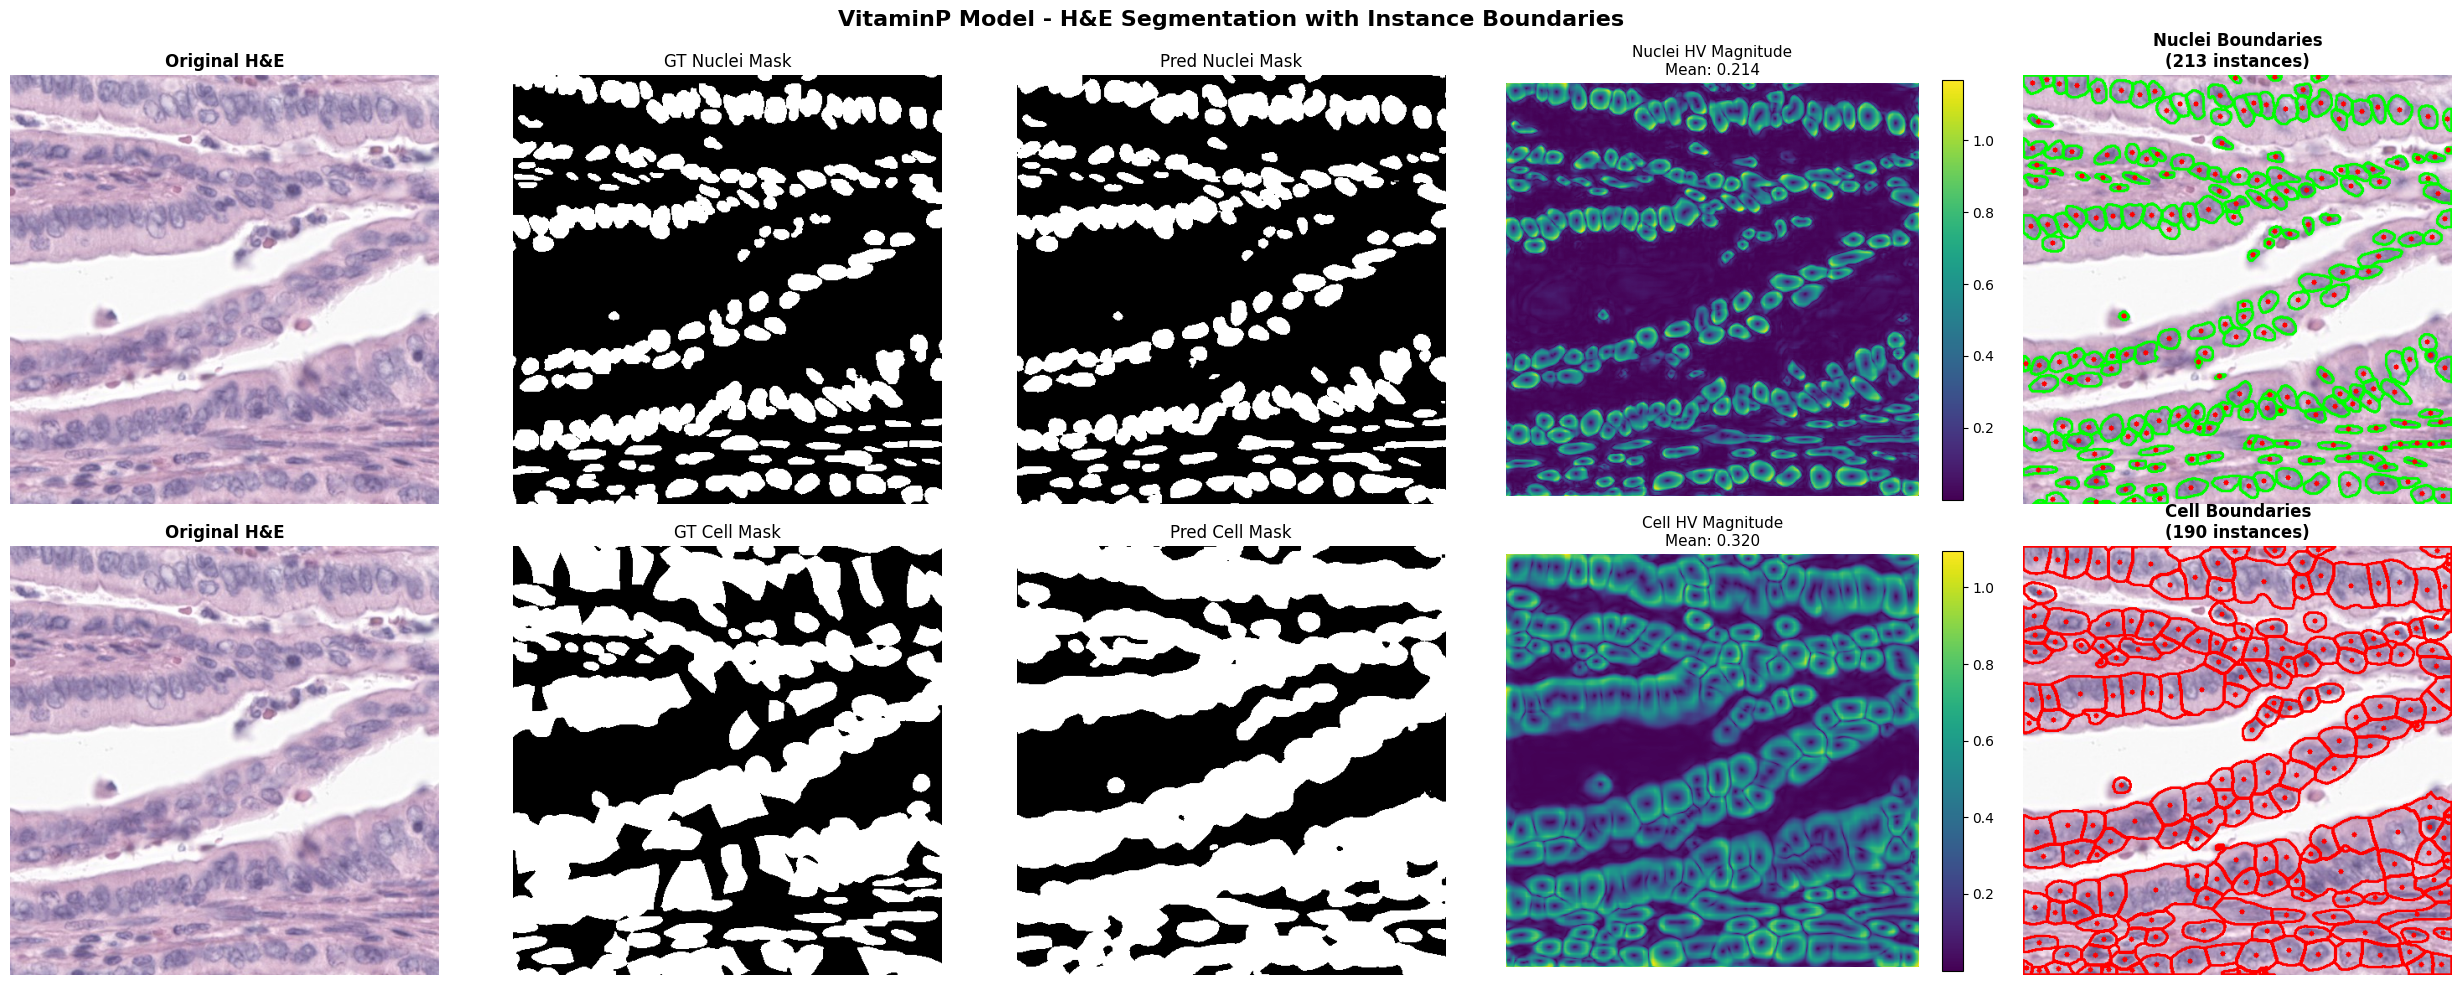


📊 METRICS:
  Nuclei Dice: 0.9027 | 213 instances detected
  Cell Dice:   0.8030 | 190 instances detected


In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from vitaminp import VitaminPFlex, SimplePreprocessing, prepare_he_input
from postprocessing import process_model_outputs
from metrics import dice_coefficient

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VitaminPFlex(model_size='large').to(device)
model.load_state_dict(torch.load("checkpoints/vitamin_p_flex_large_fold2_best.pth", map_location=device))
model.eval()

preprocessor = SimplePreprocessing()

# Get a random batch and random sample from it
import random
batch_idx = random.randint(0, len(test_loader) - 1)
for i, batch in enumerate(test_loader):
    if i == batch_idx:
        break

idx = random.randint(0, batch['he_image'].shape[0] - 1)
print(f"Selected batch {batch_idx}, sample {idx}")

# Prepare input
he_img = prepare_he_input(batch['he_image'].to(device))
he_img = preprocessor.percentile_normalize(he_img)

# Get predictions
with torch.no_grad():
    outputs = model(he_img)
    
    # Nuclei predictions
    pred_nuclei_mask = (outputs['he_nuclei_seg'][idx, 0] > 0.5).float().cpu().numpy()
    pred_nuclei_hv = outputs['he_nuclei_hv'][idx].cpu().numpy()  # [2, 512, 512]
    
    # Cell predictions
    pred_cell_mask = (outputs['he_cell_seg'][idx, 0] > 0.5).float().cpu().numpy()
    pred_cell_hv = outputs['he_cell_hv'][idx].cpu().numpy()  # [2, 512, 512]

# Ground truth
gt_nuclei = batch['he_nuclei_mask'][idx].cpu().numpy()
gt_cell = batch['he_cell_mask'][idx].cpu().numpy()
original = batch['he_image'][idx].permute(1, 2, 0).cpu().numpy()

# ============================================================================
# POST-PROCESSING TO GET INSTANCES
# ============================================================================
print("Processing nuclei instances...")
nuclei_inst, nuclei_info, num_nuclei = process_model_outputs(
    seg_pred=pred_nuclei_mask,
    h_map=pred_nuclei_hv[0],  # Horizontal map
    v_map=pred_nuclei_hv[1],  # Vertical map
    magnification=40
)
print(f"✓ Detected {num_nuclei} nuclei instances")

print("Processing cell instances...")
cell_inst, cell_info, num_cells = process_model_outputs(
    seg_pred=pred_cell_mask,
    h_map=pred_cell_hv[0],  # Horizontal map
    v_map=pred_cell_hv[1],  # Vertical map
    magnification=40
)
print(f"✓ Detected {num_cells} cell instances")

# ============================================================================
# DRAW CONTOURS FUNCTION
# ============================================================================
def draw_contours_simple(image, inst_info_dict, color=(0, 255, 0), thickness=2):
    """Draw instance contours on image"""
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8)
    
    if len(image.shape) == 2:
        output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    elif image.shape[2] == 3:
        output = image.copy()
    
    for inst_id, inst_data in inst_info_dict.items():
        contour = inst_data['contour']
        if contour.shape[0] >= 3:
            cv2.drawContours(output, [contour], -1, color, thickness)
        
        centroid = inst_data['centroid'].astype(int)
        cv2.circle(output, tuple(centroid), 3, (255, 0, 0), -1)
    
    return output

# Draw contours
img_uint8 = (original * 255).astype(np.uint8) if original.max() <= 1.0 else original.astype(np.uint8)

nuclei_contours = draw_contours_simple(img_uint8.copy(), nuclei_info, color=(0, 255, 0), thickness=2)
cell_contours = draw_contours_simple(img_uint8.copy(), cell_info, color=(255, 0, 0), thickness=2)

# Create HV magnitude maps for visualization
nuclei_hv_mag = np.sqrt(pred_nuclei_hv[0]**2 + pred_nuclei_hv[1]**2)
cell_hv_mag = np.sqrt(pred_cell_hv[0]**2 + pred_cell_hv[1]**2)

# ============================================================================
# VISUALIZATION
# ============================================================================
fig, axes = plt.subplots(2, 5, figsize=(25, 10))

# Row 1: Nuclei
axes[0, 0].imshow(original)
axes[0, 0].set_title('Original H&E', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(gt_nuclei, cmap='gray')
axes[0, 1].set_title('GT Nuclei Mask', fontsize=12)
axes[0, 1].axis('off')

axes[0, 2].imshow(pred_nuclei_mask, cmap='gray')
axes[0, 2].set_title('Pred Nuclei Mask', fontsize=12)
axes[0, 2].axis('off')

im1 = axes[0, 3].imshow(nuclei_hv_mag, cmap='viridis')
axes[0, 3].set_title(f'Nuclei HV Magnitude\nMean: {nuclei_hv_mag.mean():.3f}', fontsize=11)
axes[0, 3].axis('off')
plt.colorbar(im1, ax=axes[0, 3], fraction=0.046)

axes[0, 4].imshow(nuclei_contours)
axes[0, 4].set_title(f'Nuclei Boundaries\n({num_nuclei} instances)', fontsize=12, fontweight='bold')
axes[0, 4].axis('off')

# Row 2: Cells
axes[1, 0].imshow(original)
axes[1, 0].set_title('Original H&E', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(gt_cell, cmap='gray')
axes[1, 1].set_title('GT Cell Mask', fontsize=12)
axes[1, 1].axis('off')

axes[1, 2].imshow(pred_cell_mask, cmap='gray')
axes[1, 2].set_title('Pred Cell Mask', fontsize=12)
axes[1, 2].axis('off')

im2 = axes[1, 3].imshow(cell_hv_mag, cmap='viridis')
axes[1, 3].set_title(f'Cell HV Magnitude\nMean: {cell_hv_mag.mean():.3f}', fontsize=11)
axes[1, 3].axis('off')
plt.colorbar(im2, ax=axes[1, 3], fraction=0.046)

axes[1, 4].imshow(cell_contours)
axes[1, 4].set_title(f'Cell Boundaries\n({num_cells} instances)', fontsize=12, fontweight='bold')
axes[1, 4].axis('off')

plt.suptitle('VitaminP Model - H&E Segmentation with Instance Boundaries', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print metrics
nuclei_dice = dice_coefficient(torch.from_numpy(pred_nuclei_mask).unsqueeze(0), torch.from_numpy(gt_nuclei).unsqueeze(0))
cell_dice = dice_coefficient(torch.from_numpy(pred_cell_mask).unsqueeze(0), torch.from_numpy(gt_cell).unsqueeze(0))

print(f"\n📊 METRICS:")
print(f"  Nuclei Dice: {nuclei_dice:.4f} | {num_nuclei} instances detected")
print(f"  Cell Dice:   {cell_dice:.4f} | {num_cells} instances detected")

## Chunk of Zarr

In [15]:
!pip install imagecodecs

Defaulting to user installation because normal site-packages is not writeable
  Using cached imagecodecs-2025.11.11-cp311-abi3-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (20 kB)
Using cached imagecodecs-2025.11.11-cp311-abi3-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (23.2 MB)

[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


✓ VitaminPFlex initialized with large backbone
  Architecture: Shared Encoder → 4 Separate Decoders
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]
Opening image: /rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/ORION-CRC/CRC21/19510_C21_US_SCAN_OR_001__153607-registered.ome.tif
Image shape: (50069, 90953, 3)
Image dtype: uint8
Image chunks: (1024, 1024, 3)
Extracted chunk shape: (512, 512, 3)
Running inference...
✓ Inference complete
Processing nuclei instances...
✓ Detected 117 nuclei instances
Processing cell instances...
✓ Detected 137 cell instances
✓ Saved visualization to: vitaminp_inference_result.png


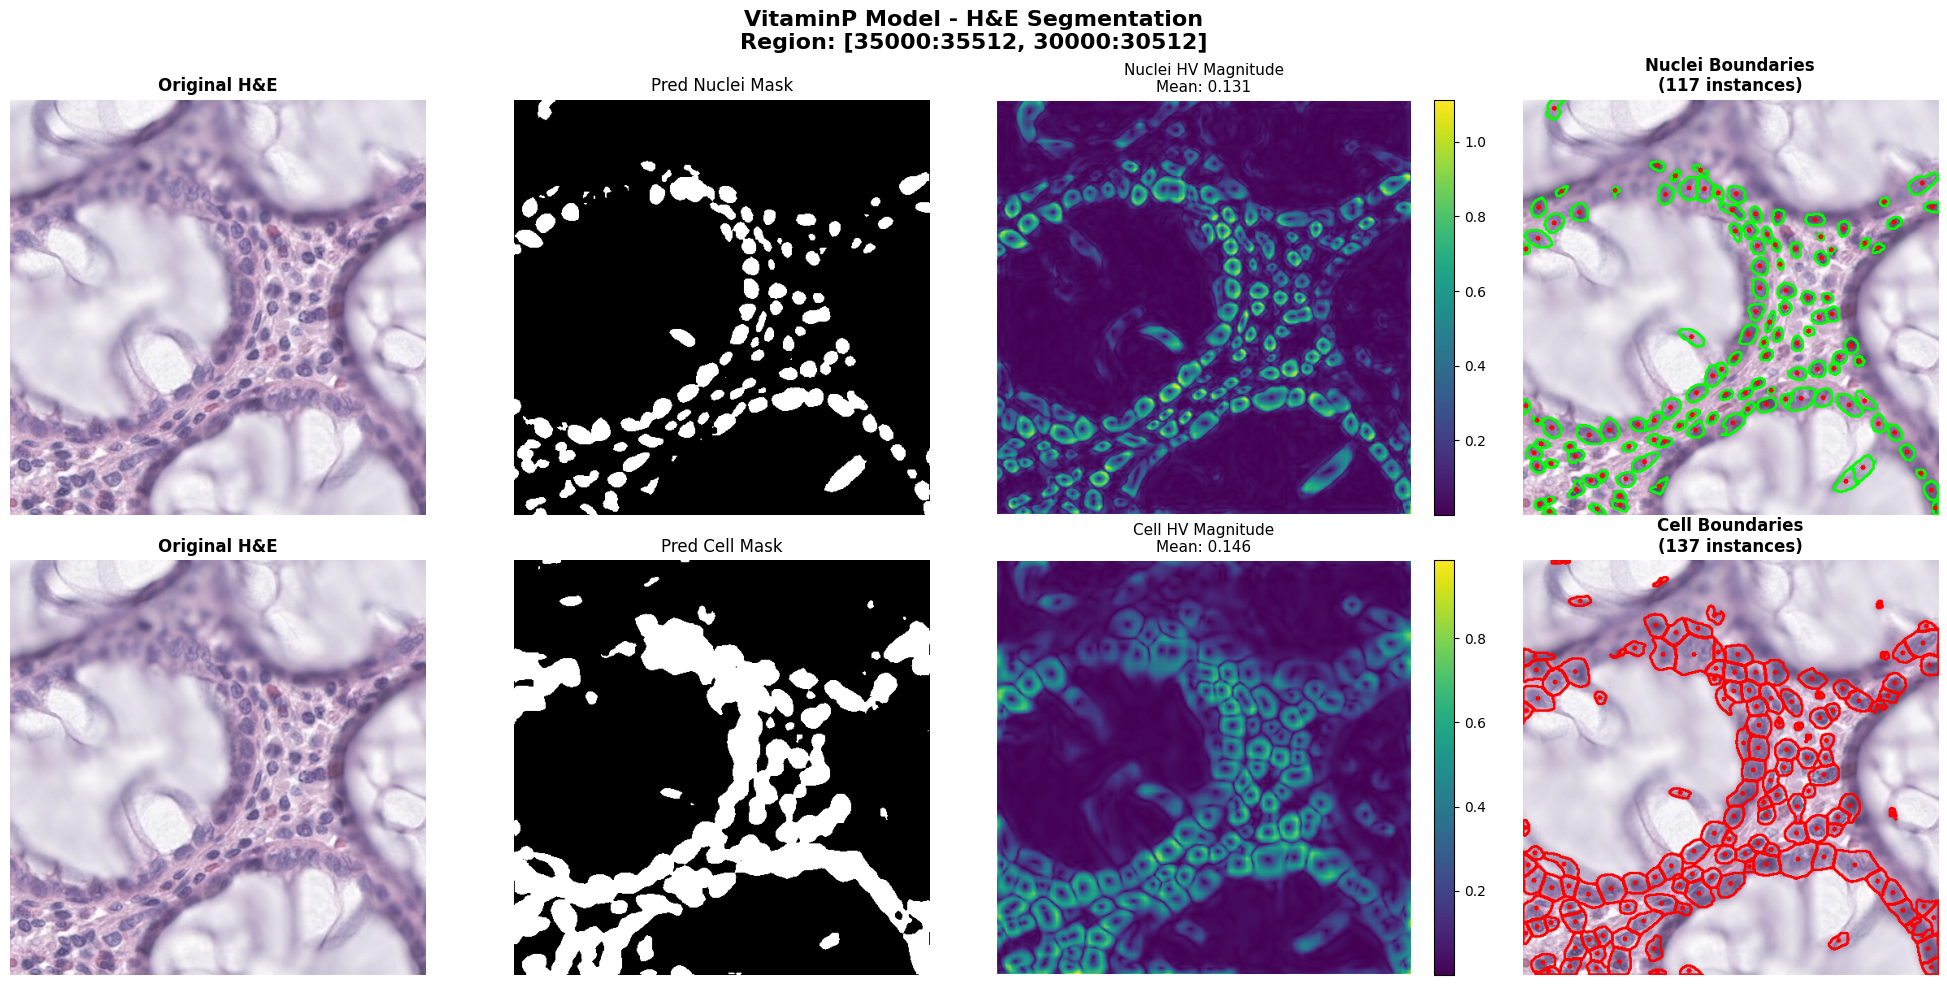


📊 RESULTS:
  Image region: [35000:35512, 30000:30512]
  Nuclei: 117 instances detected
  Cells:  137 instances detected


In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tifffile
from vitaminp import VitaminPFlex, SimplePreprocessing, prepare_he_input
from postprocessing import process_model_outputs
from metrics import dice_coefficient
import zarr
# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VitaminPFlex(model_size='large').to(device)
model.load_state_dict(torch.load("checkpoints/vitamin_p_flex_large_fold2_best.pth", map_location=device))
model.eval()

preprocessor = SimplePreprocessing()

# ============================================================================
# LOAD IMAGE FROM OME-TIFF USING TIFFFILE + ZARR
# ============================================================================
image_path = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/ORION-CRC/CRC21/19510_C21_US_SCAN_OR_001__153607-registered.ome.tif"

# Open the OME-TIFF file with tifffile and get zarr store
print(f"Opening image: {image_path}")
with tifffile.TiffFile(image_path) as tif:
    # Get the zarr store from the first series (usually the full resolution image)
    store = tif.aszarr(series=0, level=0)
    img_array = zarr.open(store, mode='r')
    
    print(f"Image shape: {img_array.shape}")
    print(f"Image dtype: {img_array.dtype}")
    print(f"Image chunks: {img_array.chunks}")
    
    # Extract a 512x512 chunk
    # You can modify these coordinates to extract from different regions
    start_y = 35000  # Starting Y coordinate
    start_x = 30000  # Starting X coordinate
    patch_size = 512
    
    # Handle different image formats
    # OME-TIFF from whole slide scanners is typically (Y, X, C) or (C, Y, X)
    if len(img_array.shape) == 3:
        if img_array.shape[2] <= 4:  # YXC format (height, width, channels)
            chunk = img_array[start_y:start_y+patch_size, start_x:start_x+patch_size, :3]
        elif img_array.shape[0] <= 4:  # CYX format (channels, height, width)
            chunk = img_array[:3, start_y:start_y+patch_size, start_x:start_x+patch_size]
            chunk = np.transpose(chunk, (1, 2, 0))  # Convert to YXC
        else:
            raise ValueError(f"Unexpected image shape: {img_array.shape}")
    elif len(img_array.shape) == 2:  # Grayscale
        chunk = img_array[start_y:start_y+patch_size, start_x:start_x+patch_size]
        chunk = np.stack([chunk, chunk, chunk], axis=-1)  # Convert to RGB
    else:
        raise ValueError(f"Unexpected image shape: {img_array.shape}")
    
    print(f"Extracted chunk shape: {chunk.shape}")

# Normalize to [0, 1] if needed
if chunk.dtype == np.uint8:
    chunk = chunk.astype(np.float32) / 255.0
elif chunk.dtype == np.uint16:
    chunk = chunk.astype(np.float32) / 65535.0
elif chunk.max() > 1.0:
    chunk = chunk.astype(np.float32) / chunk.max()

original = chunk.copy()

# ============================================================================
# PREPARE INPUT FOR MODEL
# ============================================================================
# Convert to torch tensor and prepare input (expects CYX format)
he_img_tensor = torch.from_numpy(chunk).permute(2, 0, 1).unsqueeze(0).float().to(device)  # [1, 3, 512, 512]
he_img = prepare_he_input(he_img_tensor)
he_img = preprocessor.percentile_normalize(he_img)

# ============================================================================
# GET PREDICTIONS
# ============================================================================
print("Running inference...")
with torch.no_grad():
    outputs = model(he_img)
    
    # Nuclei predictions
    pred_nuclei_mask = (outputs['he_nuclei_seg'][0, 0] > 0.5).float().cpu().numpy()
    pred_nuclei_hv = outputs['he_nuclei_hv'][0].cpu().numpy()  # [2, 512, 512]
    
    # Cell predictions
    pred_cell_mask = (outputs['he_cell_seg'][0, 0] > 0.5).float().cpu().numpy()
    pred_cell_hv = outputs['he_cell_hv'][0].cpu().numpy()  # [2, 512, 512]

print("✓ Inference complete")

# ============================================================================
# POST-PROCESSING TO GET INSTANCES
# ============================================================================
print("Processing nuclei instances...")
nuclei_inst, nuclei_info, num_nuclei = process_model_outputs(
    seg_pred=pred_nuclei_mask,
    h_map=pred_nuclei_hv[0],  # Horizontal map
    v_map=pred_nuclei_hv[1],  # Vertical map
    magnification=40
)
print(f"✓ Detected {num_nuclei} nuclei instances")

print("Processing cell instances...")
cell_inst, cell_info, num_cells = process_model_outputs(
    seg_pred=pred_cell_mask,
    h_map=pred_cell_hv[0],  # Horizontal map
    v_map=pred_cell_hv[1],  # Vertical map
    magnification=40
)
print(f"✓ Detected {num_cells} cell instances")

# ============================================================================
# DRAW CONTOURS FUNCTION
# ============================================================================
def draw_contours_simple(image, inst_info_dict, color=(0, 255, 0), thickness=2):
    """Draw instance contours on image"""
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8)
    
    if len(image.shape) == 2:
        output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    elif image.shape[2] == 3:
        output = image.copy()
    
    for inst_id, inst_data in inst_info_dict.items():
        contour = inst_data['contour']
        if contour.shape[0] >= 3:
            cv2.drawContours(output, [contour], -1, color, thickness)
        
        centroid = inst_data['centroid'].astype(int)
        cv2.circle(output, tuple(centroid), 3, (255, 0, 0), -1)
    
    return output

# Draw contours
img_uint8 = (original * 255).astype(np.uint8) if original.max() <= 1.0 else original.astype(np.uint8)

nuclei_contours = draw_contours_simple(img_uint8.copy(), nuclei_info, color=(0, 255, 0), thickness=2)
cell_contours = draw_contours_simple(img_uint8.copy(), cell_info, color=(255, 0, 0), thickness=2)

# Create HV magnitude maps for visualization
nuclei_hv_mag = np.sqrt(pred_nuclei_hv[0]**2 + pred_nuclei_hv[1]**2)
cell_hv_mag = np.sqrt(pred_cell_hv[0]**2 + pred_cell_hv[1]**2)

# ============================================================================
# VISUALIZATION
# ============================================================================
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Row 1: Nuclei
axes[0, 0].imshow(original)
axes[0, 0].set_title('Original H&E', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(pred_nuclei_mask, cmap='gray')
axes[0, 1].set_title('Pred Nuclei Mask', fontsize=12)
axes[0, 1].axis('off')

im1 = axes[0, 2].imshow(nuclei_hv_mag, cmap='viridis')
axes[0, 2].set_title(f'Nuclei HV Magnitude\nMean: {nuclei_hv_mag.mean():.3f}', fontsize=11)
axes[0, 2].axis('off')
plt.colorbar(im1, ax=axes[0, 2], fraction=0.046)

axes[0, 3].imshow(nuclei_contours)
axes[0, 3].set_title(f'Nuclei Boundaries\n({num_nuclei} instances)', fontsize=12, fontweight='bold')
axes[0, 3].axis('off')

# Row 2: Cells
axes[1, 0].imshow(original)
axes[1, 0].set_title('Original H&E', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(pred_cell_mask, cmap='gray')
axes[1, 1].set_title('Pred Cell Mask', fontsize=12)
axes[1, 1].axis('off')

im2 = axes[1, 2].imshow(cell_hv_mag, cmap='viridis')
axes[1, 2].set_title(f'Cell HV Magnitude\nMean: {cell_hv_mag.mean():.3f}', fontsize=11)
axes[1, 2].axis('off')
plt.colorbar(im2, ax=axes[1, 2], fraction=0.046)

axes[1, 3].imshow(cell_contours)
axes[1, 3].set_title(f'Cell Boundaries\n({num_cells} instances)', fontsize=12, fontweight='bold')
axes[1, 3].axis('off')

plt.suptitle(f'VitaminP Model - H&E Segmentation\nRegion: [{start_y}:{start_y+patch_size}, {start_x}:{start_x+patch_size}]', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('vitaminp_inference_result.png', dpi=150, bbox_inches='tight')
print(f"✓ Saved visualization to: vitaminp_inference_result.png")
plt.show()

# Print summary
print(f"\n📊 RESULTS:")
print(f"  Image region: [{start_y}:{start_y+patch_size}, {start_x}:{start_x+patch_size}]")
print(f"  Nuclei: {num_nuclei} instances detected")
print(f"  Cells:  {num_cells} instances detected")

## mIF predictions

In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from vitaminp import VitaminPFlex, SimplePreprocessing, prepare_mif_input
from postprocessing import process_model_outputs
from metrics import dice_coefficient

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VitaminPFlex(model_size='large').to(device)
model.load_state_dict(torch.load("checkpoints/vitamin_p_flex_large_fold2_best.pth", map_location=device))
model.eval()

preprocessor = SimplePreprocessing()

# Get a random batch and random sample from it
import random
batch_idx = random.randint(0, len(test_loader) - 1)
for i, batch in enumerate(val_loader):
    if i == batch_idx:
        break

idx = random.randint(0, batch['mif_image'].shape[0] - 1)

# ============================================================================
# SAMPLE IDENTIFICATION
# ============================================================================
print("="*80)
print("SAMPLE IDENTIFICATION")
print("="*80)
print(f"Batch Index: {batch_idx} / {len(val_loader)}")
print(f"Sample Index in Batch: {idx} / {batch['mif_image'].shape[0]}")

# Get sample metadata (now available after dataset modification)
sample_name = batch['sample_name'][idx]
patch_idx = batch['patch_idx'][idx].item() if torch.is_tensor(batch['patch_idx']) else batch['patch_idx'][idx]

print(f"Sample Name: {sample_name}")
print(f"Patch Index: {patch_idx}")

# Determine cancer type
if sample_name.startswith('CRC'):
    dataset_type = 'CRC'
    # Extract CRC number
    crc_num = sample_name.replace('CRC', '').split('_')[0]
    print(f"Cancer Type: CRC (Sample {crc_num})")
else:
    dataset_type = 'Xenium'
    print(f"Cancer Type: Xenium ({sample_name})")

# Calculate global sample index
global_idx = batch_idx * batch['mif_image'].shape[0] + idx
print(f"Global Sample Index: {global_idx}")
print("="*80)

# Prepare input
mif_img = prepare_mif_input(batch['mif_image'].to(device))
mif_img = preprocessor.percentile_normalize(mif_img)

# Get predictions
with torch.no_grad():
    outputs = model(mif_img)
    
    # Nuclei predictions
    pred_nuclei_mask = (outputs['mif_nuclei_seg'][idx, 0] > 0.5).float().cpu().numpy()
    pred_nuclei_hv = outputs['mif_nuclei_hv'][idx].cpu().numpy()  # [2, 512, 512]
    
    # Cell predictions
    pred_cell_mask = (outputs['mif_cell_seg'][idx, 0] > 0.5).float().cpu().numpy()
    pred_cell_hv = outputs['mif_cell_hv'][idx].cpu().numpy()  # [2, 512, 512]

# Ground truth
original_mif = batch['mif_image'][idx].cpu().numpy()  # [2, 512, 512]

# Try different possible key names for ground truth
if 'mif_nuclei_mask' in batch:
    gt_nuclei = batch['mif_nuclei_mask'][idx].cpu().numpy()
elif 'mif_nucleus_mask' in batch:
    gt_nuclei = batch['mif_nucleus_mask'][idx].cpu().numpy()
else:
    print("⚠️ Could not find nuclei GT mask")
    gt_nuclei = np.zeros((512, 512))

if 'mif_cell_mask' in batch:
    gt_cell = batch['mif_cell_mask'][idx].cpu().numpy()
elif 'mif_cells_mask' in batch:
    gt_cell = batch['mif_cells_mask'][idx].cpu().numpy()
else:
    print("⚠️ Could not find cell GT mask")
    gt_cell = np.zeros((512, 512))

# ============================================================================
# GT MASK ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("GROUND TRUTH MASK ANALYSIS")
print("="*80)
gt_nuclei_pixels = gt_nuclei.sum()
gt_cell_pixels = gt_cell.sum()
gt_nuclei_pct = 100 * gt_nuclei.mean()
gt_cell_pct = 100 * gt_cell.mean()

print(f"GT Nuclei:")
print(f"  Unique values: {np.unique(gt_nuclei)}")
print(f"  Total pixels: {gt_nuclei_pixels:.0f} ({gt_nuclei_pct:.2f}%)")
print(f"  Shape: {gt_nuclei.shape}")

print(f"\nGT Cell:")
print(f"  Unique values: {np.unique(gt_cell)}")
print(f"  Total pixels: {gt_cell_pixels:.0f} ({gt_cell_pct:.2f}%)")
print(f"  Shape: {gt_cell.shape}")

print(f"\nMask Comparison:")
print(f"  Are masks identical? {np.array_equal(gt_nuclei, gt_cell)}")
print(f"  Overlap pixels: {(gt_nuclei * gt_cell).sum():.0f}")
print(f"  Nuclei only: {((gt_nuclei > 0) & (gt_cell == 0)).sum():.0f}")
print(f"  Cell only: {((gt_cell > 0) & (gt_nuclei == 0)).sum():.0f}")

# Check for potential issues
if np.array_equal(gt_nuclei, gt_cell):
    print("⚠️  WARNING: Nuclei and Cell GT masks are IDENTICAL!")
if gt_nuclei_pixels == 0:
    print("⚠️  WARNING: Nuclei GT mask is EMPTY!")
if gt_cell_pixels == 0:
    print("⚠️  WARNING: Cell GT mask is EMPTY!")
if gt_nuclei_pct > 60:
    print(f"⚠️  WARNING: Nuclei GT coverage is very high ({gt_nuclei_pct:.1f}%)!")
if gt_cell_pct > 60:
    print(f"⚠️  WARNING: Cell GT coverage is very high ({gt_cell_pct:.1f}%)!")

print("="*80)

# Create RGB visualization from 2-channel MIF - BRIGHTER
mif_rgb = np.zeros((512, 512, 3), dtype=np.float32)
mif_rgb[:, :, 0] = original_mif[0]  # Red channel
mif_rgb[:, :, 1] = original_mif[1]  # Green channel

# Normalize and brighten
mif_rgb = (mif_rgb - mif_rgb.min()) / (mif_rgb.max() - mif_rgb.min() + 1e-8)
mif_rgb = np.clip(mif_rgb * 1.5, 0, 1)  # Brighten by 1.5x

# ============================================================================
# POST-PROCESSING TO GET INSTANCES
# ============================================================================
print("\nProcessing nuclei instances...")
nuclei_inst, nuclei_info, num_nuclei = process_model_outputs(
    seg_pred=pred_nuclei_mask,
    h_map=pred_nuclei_hv[0],
    v_map=pred_nuclei_hv[1],
    magnification=40
)
print(f"✓ Detected {num_nuclei} nuclei instances")

print("Processing cell instances...")
cell_inst, cell_info, num_cells = process_model_outputs(
    seg_pred=pred_cell_mask,
    h_map=pred_cell_hv[0],
    v_map=pred_cell_hv[1],
    magnification=40
)
print(f"✓ Detected {num_cells} cell instances")

# ============================================================================
# DRAW CONTOURS FUNCTION
# ============================================================================
def draw_contours_simple(image, inst_info_dict, color=(0, 255, 0), thickness=2):
    """Draw instance contours on image"""
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8)
    
    if len(image.shape) == 2:
        output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    elif image.shape[2] == 3:
        output = image.copy()
    
    for inst_id, inst_data in inst_info_dict.items():
        contour = inst_data['contour']
        if contour.shape[0] >= 3:
            cv2.drawContours(output, [contour], -1, color, thickness)
        
        centroid = inst_data['centroid'].astype(int)
        cv2.circle(output, tuple(centroid), 3, (255, 255, 0), -1)
    
    return output

# Draw contours
mif_rgb_uint8 = (mif_rgb * 255).astype(np.uint8)

nuclei_contours = draw_contours_simple(mif_rgb_uint8.copy(), nuclei_info, 
                                       color=(0, 100, 255), thickness=2)  # BLUE
cell_contours = draw_contours_simple(mif_rgb_uint8.copy(), cell_info, 
                                     color=(0, 255, 0), thickness=2)  # GREEN

# Create HV magnitude maps
nuclei_hv_mag = np.sqrt(pred_nuclei_hv[0]**2 + pred_nuclei_hv[1]**2)
cell_hv_mag = np.sqrt(pred_cell_hv[0]**2 + pred_cell_hv[1]**2)

# ============================================================================
# VISUALIZATION
# ============================================================================
fig, axes = plt.subplots(2, 5, figsize=(25, 10))

# Row 1: Nuclei
axes[0, 0].imshow(mif_rgb)
axes[0, 0].set_title('Original MIF (Brightened)\n(R=Ch0, G=Ch1)', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(gt_nuclei, cmap='gray')
axes[0, 1].set_title(f'GT Nuclei Mask\n({gt_nuclei_pixels:.0f} pixels, {gt_nuclei_pct:.1f}%)', fontsize=12)
axes[0, 1].axis('off')

axes[0, 2].imshow(pred_nuclei_mask, cmap='gray')
axes[0, 2].set_title(f'Pred Nuclei Mask\n({pred_nuclei_mask.sum():.0f} pixels)', fontsize=12)
axes[0, 2].axis('off')

im1 = axes[0, 3].imshow(nuclei_hv_mag, cmap='viridis')
axes[0, 3].set_title(f'Nuclei HV Magnitude\nMean: {nuclei_hv_mag.mean():.3f}', fontsize=11)
axes[0, 3].axis('off')
plt.colorbar(im1, ax=axes[0, 3], fraction=0.046)

axes[0, 4].imshow(nuclei_contours)
axes[0, 4].set_title(f'Nuclei Boundaries (BLUE)\n({num_nuclei} instances)', fontsize=12, fontweight='bold')
axes[0, 4].axis('off')

# Row 2: Cells
axes[1, 0].imshow(mif_rgb)
axes[1, 0].set_title('Original MIF (Brightened)\n(R=Ch0, G=Ch1)', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(gt_cell, cmap='gray')
axes[1, 1].set_title(f'GT Cell Mask\n({gt_cell_pixels:.0f} pixels, {gt_cell_pct:.1f}%)', fontsize=12)
axes[1, 1].axis('off')

axes[1, 2].imshow(pred_cell_mask, cmap='gray')
axes[1, 2].set_title(f'Pred Cell Mask\n({pred_cell_mask.sum():.0f} pixels)', fontsize=12)
axes[1, 2].axis('off')

im2 = axes[1, 3].imshow(cell_hv_mag, cmap='viridis')
axes[1, 3].set_title(f'Cell HV Magnitude\nMean: {cell_hv_mag.mean():.3f}', fontsize=11)
axes[1, 3].axis('off')
plt.colorbar(im2, ax=axes[1, 3], fraction=0.046)

axes[1, 4].imshow(cell_contours)
axes[1, 4].set_title(f'Cell Boundaries (GREEN)\n({num_cells} instances)', fontsize=12, fontweight='bold')
axes[1, 4].axis('off')

# Add sample info to title
title = f'VitaminP Model - MIF Segmentation | Batch {batch_idx}, Sample {idx}'
if 'case_id' in batch:
    title += f' | Case {case_id}'
plt.suptitle(title, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print metrics
# Calculate metrics
nuclei_dice = dice_coefficient(
    torch.from_numpy(pred_nuclei_mask).unsqueeze(0),
    torch.from_numpy(gt_nuclei).unsqueeze(0)
)
nuclei_dice = nuclei_dice.item() if hasattr(nuclei_dice, 'item') else nuclei_dice

cell_dice = dice_coefficient(
    torch.from_numpy(pred_cell_mask).unsqueeze(0),
    torch.from_numpy(gt_cell).unsqueeze(0)
)
cell_dice = cell_dice.item() if hasattr(cell_dice, 'item') else cell_dice
print(f"\n📊 METRICS:")
print(f"  Nuclei Dice: {nuclei_dice:.4f} | {num_nuclei} instances detected")
print(f"  Cell Dice:   {cell_dice:.4f} | {num_cells} instances detected")

✓ VitaminPFlex initialized with large backbone
  Architecture: Shared Encoder → 4 Separate Decoders
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]


NameError: name 'test_loader' is not defined

## Sample based

In [9]:
import torch
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from vitaminp import VitaminPFlex, SimplePreprocessing, prepare_mif_input
from postprocessing import process_model_outputs
from metrics import dice_coefficient

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VitaminPFlex(model_size='large').to(device)
model.load_state_dict(torch.load("checkpoints/vitamin_p_flex_large_fold2_best.pth", map_location=device))
model.eval()

preprocessor = SimplePreprocessing()

# ============================================================================
# EVALUATE ALL SAMPLES AND TRACK BY SAMPLE NAME
# ============================================================================

# Dictionary to store metrics per sample
sample_metrics = defaultdict(lambda: {
    'nuclei_dice': [],
    'cell_dice': [],
    'num_nuclei': [],
    'num_cells': [],
    'patch_count': 0
})

print("Evaluating all samples...")
print("="*80)

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(test_loader, desc="Processing batches")):
        # Get sample metadata
        sample_names = batch['sample_name']
        patch_indices = batch['patch_idx']
        
        # Prepare input
        mif_img = prepare_mif_input(batch['mif_image'].to(device))
        mif_img = preprocessor.percentile_normalize(mif_img)
        
        # Get predictions
        outputs = model(mif_img)
        
        # Process each sample in batch
        batch_size = batch['mif_image'].shape[0]
        for idx in range(batch_size):
            sample_name = sample_names[idx]
            patch_idx = patch_indices[idx].item() if torch.is_tensor(patch_indices[idx]) else patch_indices[idx]
            
            # Get predictions for this sample
            pred_nuclei_mask = (outputs['mif_nuclei_seg'][idx, 0] > 0.5).float().cpu().numpy()
            pred_cell_mask = (outputs['mif_cell_seg'][idx, 0] > 0.5).float().cpu().numpy()
            
            # Get ground truth
            gt_nuclei = batch['mif_nuclei_mask'][idx].cpu().numpy()
            gt_cell = batch['mif_cell_mask'][idx].cpu().numpy()
            
            # Calculate metrics
            # Calculate metrics
            nuclei_dice = dice_coefficient(
                torch.from_numpy(pred_nuclei_mask).unsqueeze(0),
                torch.from_numpy(gt_nuclei).unsqueeze(0)
            )
            nuclei_dice = nuclei_dice.item() if hasattr(nuclei_dice, 'item') else nuclei_dice
            
            cell_dice = dice_coefficient(
                torch.from_numpy(pred_cell_mask).unsqueeze(0),
                torch.from_numpy(gt_cell).unsqueeze(0)
            )
            cell_dice = cell_dice.item() if hasattr(cell_dice, 'item') else cell_dice
            
            # Get instance counts (optional, can skip for speed)
            pred_nuclei_hv = outputs['mif_nuclei_hv'][idx].cpu().numpy()
            pred_cell_hv = outputs['mif_cell_hv'][idx].cpu().numpy()
            
            _, _, num_nuclei = process_model_outputs(
                seg_pred=pred_nuclei_mask,
                h_map=pred_nuclei_hv[0],
                v_map=pred_nuclei_hv[1],
                magnification=40
            )
            
            _, _, num_cells = process_model_outputs(
                seg_pred=pred_cell_mask,
                h_map=pred_cell_hv[0],
                v_map=pred_cell_hv[1],
                magnification=40
            )
            
            # Store metrics
            sample_metrics[sample_name]['nuclei_dice'].append(nuclei_dice)
            sample_metrics[sample_name]['cell_dice'].append(cell_dice)
            sample_metrics[sample_name]['num_nuclei'].append(num_nuclei)
            sample_metrics[sample_name]['num_cells'].append(num_cells)
            sample_metrics[sample_name]['patch_count'] += 1

# ============================================================================
# AGGREGATE AND ANALYZE RESULTS
# ============================================================================

print("\n" + "="*80)
print("RESULTS BY SAMPLE")
print("="*80)

# Separate CRC and Xenium samples
crc_samples = {}
xenium_samples = {}

for sample_name, metrics in sample_metrics.items():
    # Calculate averages
    avg_metrics = {
        'nuclei_dice_mean': np.mean(metrics['nuclei_dice']),
        'nuclei_dice_std': np.std(metrics['nuclei_dice']),
        'cell_dice_mean': np.mean(metrics['cell_dice']),
        'cell_dice_std': np.std(metrics['cell_dice']),
        'avg_num_nuclei': np.mean(metrics['num_nuclei']),
        'avg_num_cells': np.mean(metrics['num_cells']),
        'patch_count': metrics['patch_count']
    }
    
    if sample_name.startswith('CRC'):
        crc_samples[sample_name] = avg_metrics
    else:
        xenium_samples[sample_name] = avg_metrics

# Print CRC results
print("\n🔬 CRC SAMPLES:")
print("-" * 80)
print(f"{'Sample':<15} {'Patches':>8} {'Nuclei Dice':>15} {'Cell Dice':>15} {'Avg Nuclei':>12} {'Avg Cells':>12}")
print("-" * 80)

for sample_name in sorted(crc_samples.keys()):
    m = crc_samples[sample_name]
    print(f"{sample_name:<15} {m['patch_count']:>8} "
          f"{m['nuclei_dice_mean']:>8.4f}±{m['nuclei_dice_std']:<5.4f} "
          f"{m['cell_dice_mean']:>8.4f}±{m['cell_dice_std']:<5.4f} "
          f"{m['avg_num_nuclei']:>12.1f} {m['avg_num_cells']:>12.1f}")

# Print Xenium results
print("\n🔬 XENIUM SAMPLES:")
print("-" * 80)
print(f"{'Sample':<15} {'Patches':>8} {'Nuclei Dice':>15} {'Cell Dice':>15} {'Avg Nuclei':>12} {'Avg Cells':>12}")
print("-" * 80)

for sample_name in sorted(xenium_samples.keys()):
    m = xenium_samples[sample_name]
    print(f"{sample_name:<15} {m['patch_count']:>8} "
          f"{m['nuclei_dice_mean']:>8.4f}±{m['nuclei_dice_std']:<5.4f} "
          f"{m['cell_dice_mean']:>8.4f}±{m['cell_dice_std']:<5.4f} "
          f"{m['avg_num_nuclei']:>12.1f} {m['avg_num_cells']:>12.1f}")

# Print overall statistics
print("\n" + "="*80)
print("OVERALL STATISTICS")
print("="*80)

# CRC overall
if crc_samples:
    crc_nuclei_dice = [m['nuclei_dice_mean'] for m in crc_samples.values()]
    crc_cell_dice = [m['cell_dice_mean'] for m in crc_samples.values()]
    print(f"\n📊 CRC ({len(crc_samples)} samples):")
    print(f"  Nuclei Dice: {np.mean(crc_nuclei_dice):.4f} ± {np.std(crc_nuclei_dice):.4f}")
    print(f"  Cell Dice:   {np.mean(crc_cell_dice):.4f} ± {np.std(crc_cell_dice):.4f}")

# Xenium overall
if xenium_samples:
    xenium_nuclei_dice = [m['nuclei_dice_mean'] for m in xenium_samples.values()]
    xenium_cell_dice = [m['cell_dice_mean'] for m in xenium_samples.values()]
    print(f"\n📊 Xenium ({len(xenium_samples)} samples):")
    print(f"  Nuclei Dice: {np.mean(xenium_nuclei_dice):.4f} ± {np.std(xenium_nuclei_dice):.4f}")
    print(f"  Cell Dice:   {np.mean(xenium_cell_dice):.4f} ± {np.std(xenium_cell_dice):.4f}")

# Find worst performing samples
print("\n" + "="*80)
print("WORST PERFORMING SAMPLES")
print("="*80)

all_samples_with_dice = [(name, metrics['nuclei_dice_mean'], metrics['cell_dice_mean'], 'CRC' if name.startswith('CRC') else 'Xenium') 
                          for name, metrics in {**crc_samples, **xenium_samples}.items()]

# Sort by nuclei dice
sorted_by_nuclei = sorted(all_samples_with_dice, key=lambda x: x[1])
print("\n🔴 Lowest Nuclei Dice:")
for i, (name, nuclei_dice, cell_dice, cancer_type) in enumerate(sorted_by_nuclei[:5]):
    print(f"  {i+1}. {name:<15} ({cancer_type:<6}): Nuclei={nuclei_dice:.4f}, Cell={cell_dice:.4f}")

# Sort by cell dice
sorted_by_cell = sorted(all_samples_with_dice, key=lambda x: x[2])
print("\n🔴 Lowest Cell Dice:")
for i, (name, nuclei_dice, cell_dice, cancer_type) in enumerate(sorted_by_cell[:5]):
    print(f"  {i+1}. {name:<15} ({cancer_type:<6}): Nuclei={nuclei_dice:.4f}, Cell={cell_dice:.4f}")

print("="*80)

✓ VitaminPFlex initialized with large backbone
  Architecture: Shared Encoder → 4 Separate Decoders
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]
Evaluating all samples...


Processing batches: 100%|██████████| 161/161 [02:24<00:00,  1.11it/s]


RESULTS BY SAMPLE

🔬 CRC SAMPLES:
--------------------------------------------------------------------------------
Sample           Patches     Nuclei Dice       Cell Dice   Avg Nuclei    Avg Cells
--------------------------------------------------------------------------------
CRC08                115   0.9032±0.0217   0.9240±0.0296        167.1        158.6
CRC09                 57   0.8982±0.0301   0.9097±0.0425        136.1        130.5
CRC10                 27   0.8953±0.0599   0.9015±0.0339        203.1        195.6
CRC11                 13   0.8781±0.0365   0.9222±0.0311        234.1        222.8
CRC12                 69   0.8946±0.0246   0.9041±0.0266         92.5         90.1
CRC13                 38   0.8987±0.0200   0.9097±0.0288        126.5        121.5
CRC40                 68   0.8778±0.0365   0.9208±0.0386        247.3        223.1

🔬 XENIUM SAMPLES:
--------------------------------------------------------------------------------
Sample           Patches     Nuclei Dic